In [16]:
import os
import pickle
import numpy as np
from cellpose import models
from cellpose.io import imread
from cellpose import plot, utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### 1, get anatomical and functional ROIs and potential place cells

In [2]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023/"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')

#load ops
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()

stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)

meanImg = ops['meanImg']

# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')

mask, flow, style, diam = model.eval(meanImg, diameter=None, channels=None, flow_threshold=1, min_size=-1, tile_overlap=0.1)

#transform meanImg to rgb
if meanImg.shape[0] < 4:
    meanImg = np.transpose(meanImg, (1,2,0))
if meanImg.shape[-1] < 3 or meanImg.ndim < 3:
    meanImg = plot.image_to_rgb(meanImg, channels=[0,0])
else:
    if meanImg.max()<=50.0:
        meanImg = np.uint8(np.clip(meanImg*255, 0, 1))


#load Potential_PC_results.pickle from the savefolder
with open(os.path.join(savefolder, 'Potential_PC_results_classifier13112023.pickle'), 'rb') as f:
    Potential_PC_results = pickle.load(f)

### 2, plot ROIs and count the number of ROIs in a bar plot

In [15]:
def find_border(img, pixel_value):
    """
    find the border of the pixel_value in img
    :param img: 3D numpy array
    :param pixel_value: 1D numpy array
    :return: 1D numpy array
    """
    index = np.where((img==pixel_value).all(axis=2))
    x_min = np.min(index[0])
    x_max = np.max(index[0])
    y_min = np.min(index[1])
    y_max = np.max(index[1])
    return np.array([x_min, x_max, y_min, y_max])

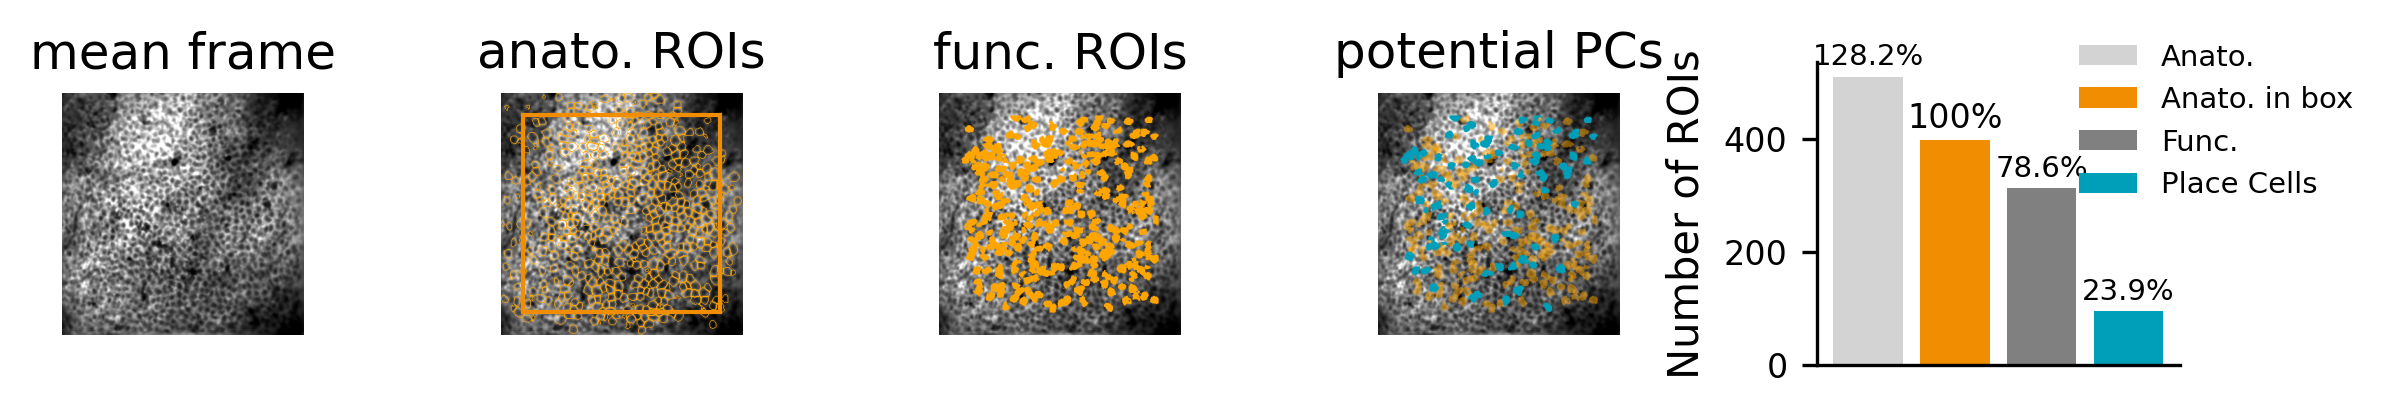

In [36]:
fig = plt.figure(figsize=(8,1.5), dpi=300)
labelsize = 10
ticksize = 8

gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 1.5])

ax0 = fig.add_subplot(gs[0])
ax0.imshow(meanImg)
ax0.set_title('mean frame')
ax0.axis('off')

#plot anatomical ROIs
ax1 = fig.add_subplot(gs[1])
outlines = utils.masks_to_outlines(mask)
outX, outY = np.nonzero(outlines)
imgout_a= meanImg.copy()
# make outlines color as orange in 0-255 scale
imgout_a[outX, outY] = np.array([255, 165, 0])

ax1.imshow(imgout_a)
ax1.set_title('anato. ROIs')
ax1.axis('off')

#plot functional ROIs   
ax2 = fig.add_subplot(gs[2])
imgout_f = meanImg.copy()
fcell_idx = np.where(iscell[:,0]==1)[0] #functional ROIs    
#for each of the N neurons, mark the pixels as red  
for idx in fcell_idx:
    #get the x and y coordinates of the neuron
    x = stats[idx]['xpix']
    y = stats[idx]['ypix']
    #mark the pixels as orange
    imgout_f[x, y, :] =  np.array([255, 165, 0])
ax2.imshow(imgout_f)
ax2.set_title('func. ROIs')
ax2.axis('off')

#plot potential place cells
ax3 = fig.add_subplot(gs[3])
imgout_pc = meanImg.copy()

#first mark the functional ROIs as orange with alpha = 0.5
for idx in fcell_idx:
    #get the x and y coordinates of the neuron
    x = stats[idx]['xpix']
    y = stats[idx]['ypix']
    #mark the pixels as orange with alpha = 0.5
    imgout_pc[x, y, :] =  np.array([255, 165, 0])*0.5 + imgout_pc[x, y, :]*0.5

pc_idx = Potential_PC_results['potentialPC_maps'].keys()
#chnage to list
pc_idx = list(pc_idx)
for idx in pc_idx:
    # get the x and y coordinates of the neuron
    # x = stats[idx]['xpix'][~stats[idx]['overlap']]
    # y = stats[idx]['ypix'][~stats[idx]['overlap']]
    x = stats[idx]['xpix']
    y = stats[idx]['ypix']
    # mark the pixels as #009FB9
    imgout_pc[x, y, :] =  np.array([0, 159, 185])
ax3.imshow(imgout_pc)
ax3.set_title('potential PCs')
ax3.axis('off')

ax4 = fig.add_subplot(gs[4])

#count the unique values in mask
unique, counts = np.unique(mask, return_counts=True)
num_anatomical_ROIs = len(unique)-1
num_functional_ROIs = len(fcell_idx)
num_potential_PCs = len(pc_idx)

#get the border of the functional ROIs
x_min, x_max, y_min, y_max = find_border(imgout_f, np.array([255, 165, 0]))
#add a rectangle to the imgout_a with color #F18D00 using patches
rect = patches.Rectangle((y_min, x_min), y_max-y_min, x_max-x_min, linewidth=1, edgecolor='#F18D00', facecolor='none')
ax1.add_patch(rect)

#get the number of neurons in the anatomical ROIs
#find the index of the neurons with all pixels inside the rectangle
num_in_box = 0
for idx in range(1, len(unique)):
    #get the x and y coordinates of the neuron by finding mask==i
    x = np.where(mask==idx)[0]
    y = np.where(mask==idx)[1]
    
    #check if all the x and y coordinates are inside the rectangle      
    if np.all((x>=x_min) & (x<=x_max) & (y>=y_min) & (y<=y_max)):
        num_in_box += 1

# Assign labels for legends
labels = ['Anato.', 'Anato. in box', 'Func.', 'Place Cells']
# Plot the bars and assign labels for legends
bars = ax4.bar([0, 1, 2, 3], [num_anatomical_ROIs, num_in_box, num_functional_ROIs, num_potential_PCs],
               color=['lightgrey', '#F18D00', 'grey', '#009FB9'], label=labels)
# Add legends on top of the plot, outside the axes
ax4.legend(bars, labels, loc='upper center', bbox_to_anchor=(1.1, 1.15), ncol=1, fontsize=7, frameon=False)
ax4.set_ylabel('Number of ROIs')
#xticks off
ax4.set_xticks([])
ax4.tick_params(axis='both', which='major', labelsize=ticksize)
#add text on the first bar as percenterage calculated as num_anatomical_ROIs/num_in_box
ax4.text(0, num_anatomical_ROIs+10, '{:.1f}%'.format(num_anatomical_ROIs/num_in_box*100), ha='center', va='bottom', fontsize=ticksize-1)
#add text on the second bar as percenterage calculated as 100%
ax4.text(1, num_in_box+10, '100%', ha='center', va='bottom', fontsize=ticksize)
#add text on the third bar as percenterage calculated as num_functional_ROIs/num_anatomical_ROIs
ax4.text(2, num_functional_ROIs+10, '{:.1f}%'.format(num_functional_ROIs/num_in_box*100), ha='center', va='bottom', fontsize=ticksize-1)
#add text on the fourth bar as percenterage calculated as num_potential_PCs/num_anatomical_ROIs
ax4.text(3, num_potential_PCs+10, '{:.1f}%'.format(num_potential_PCs/num_in_box*100), ha='center', va='bottom', fontsize=ticksize-1)
#right and top spines are not visible
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('../Figures/Figure3_ROIs.pdf', dpi=300, bbox_inches='tight')

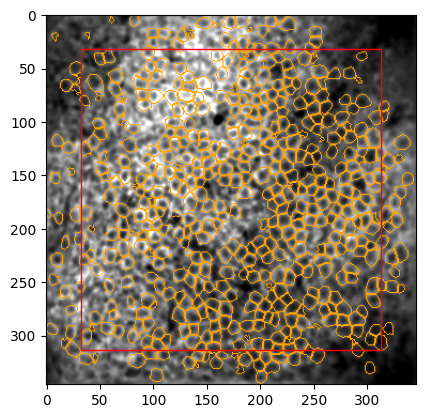

397
77.84313725490196


In [22]:
#for imgout_f, add a rectangular to bound the functional ROIs, the pixel value of ROIs is np.array([255, 165, 0])

#using imgout_f==np.array([255, 165, 0]) to get the coordinates of the functional ROIs
#then use the coordinates to get the min and max of x and y

#then use the min and max to draw a rectangle

index = np.where((imgout_f==np.array([255, 165, 0])).all(axis=2))

x_min = np.min(index[0])
x_max = np.max(index[0])
y_min = np.min(index[1])
y_max = np.max(index[1])

#draw a rectangle on imgout_a and plot it
import matplotlib.patches as patches
fig, ax = plt.subplots(1)
ax.imshow(imgout_a)
# Create a Rectangle patch
rect = patches.Rectangle((y_min, x_min), y_max-y_min, x_max-x_min, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()



In [20]:
unique

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### 3, plot the calcium traces of several ROIs

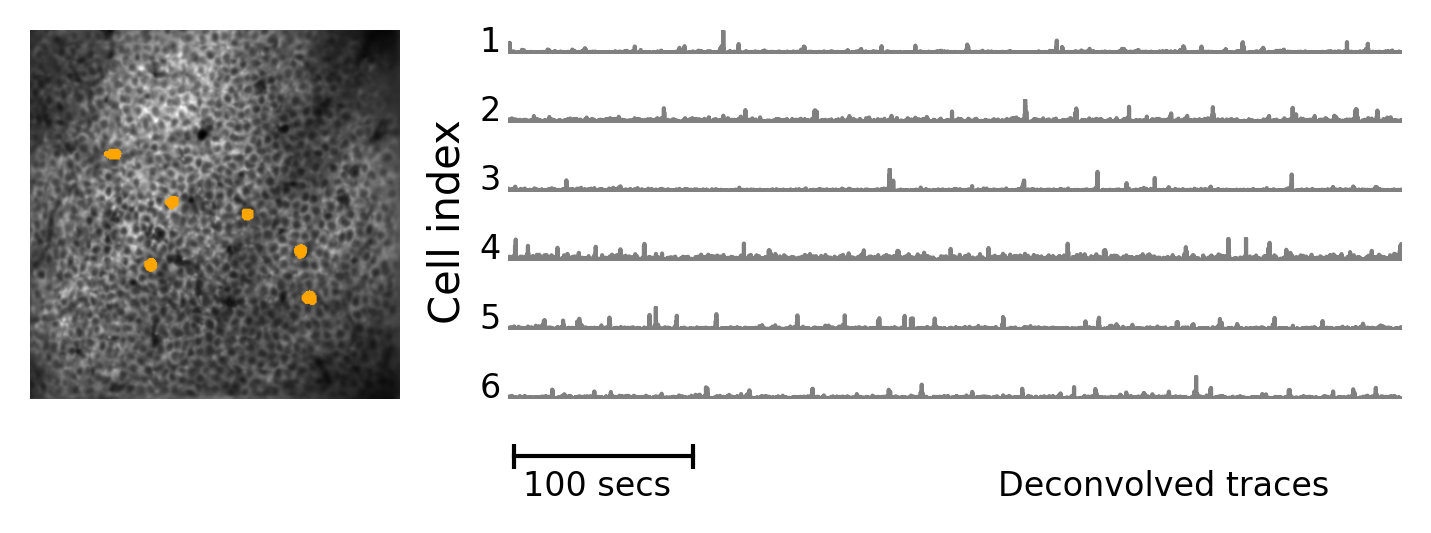

In [204]:
#select the first N neurons
potentialPC_maps = Potential_PC_results['potentialPC_maps']
N = 6
keys = list(potentialPC_maps.keys())[:N]
frame_length = 15000

#plot the traces of these 10 neurons
#each in a subplot
fig = plt.figure(figsize=(5, 2), dpi=300)
labelsize = 10
ticksize = 8

#gs = GridSpec(N+1, 2, width_ratios=[1,3]) 
gs = fig.add_gridspec(N+1, 2, width_ratios=[1,2])

#on the left show the mean image 
ax = fig.add_subplot(gs[:N, 0])
meanImage = ops['meanImg']
#transfer to RGB image
meanImage = np.stack((meanImage,)*3, axis=-1)
#normalize to [0,255] and change to uint8
meanImage = (meanImage-np.min(meanImage))/(np.max(meanImage)-np.min(meanImage))*255
meanImage = meanImage.astype(np.uint8)
#ticks off
ax.set_xticks([]); ax.set_yticks([])
#for each of the N neurons, mark the pixels as red  
for i, k in enumerate(keys):
    #get the x and y coordinates of the neuron
    x = stats[k]['xpix']
    y = stats[k]['ypix']
    #mark the pixels as orange, but 50% transparent
    meanImage[x, y, :] =  [255, 165, 0]

ax.imshow(meanImage)
ax.axis('off')

for i, k in enumerate(keys):
    ax = fig.add_subplot(gs[i, 1:])
    ax.plot(np.arange(frame_length), spks[k][:frame_length], color='grey', linewidth=1, alpha=1.0)
    ax.set_xticks([]); ax.set_yticks([])
    #box invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ylabel and move it down a bit to align with the bottom edge of the subplot
    #plt.ylabel(str(k+1), fontsize=labelsize, rotation=0, labelpad=10)
    ax.set_ylabel(str(k+1), fontsize=ticksize, rotation=0, labelpad=20)
    #adjust the ylabel to move it down
    #plt.gca().yaxis.set_label_coords(-0.02, -0.1)
    ax.yaxis.set_label_coords(-0.02, -0.2)
    #xlim
    #plt.xlim([0, frame_length])
    ax.set_xlim([0, frame_length])
    
#add a horizontal line to mark the time length of 100 seconds, whcih equals to 3000 frames  
#show with equal 
ax = fig.add_subplot(gs[N, 1:])
ax.plot([100, 3100], [0, 0], color='k', linewidth=1, alpha=1)
#add two short veritcal lines to mark the beginning and end of the 100 seconds
ax.plot([100, 100], [-0.05, 0.05], color='k', linewidth=1, alpha=1)
ax.plot([3100, 3100], [-0.05, 0.05], color='k', linewidth=1, alpha=1)
#box invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#xy ticks off
ax.set_xticks([]); ax.set_yticks([])
#xlim
ax.set_xlim([0, frame_length])
#add text below the line
ax.text(1500, -0.18, '100 secs', fontsize=ticksize, horizontalalignment='center')
ax.text(frame_length-4000, -0.18, 'Deconvolved traces', fontsize=ticksize, horizontalalignment='center')

#add a sup title on the left side of all plots
# plt.suptitle('Cell index', fontsize=labelsize,  rotation='vertical', x=0.0, y=0.52)
fig.text(0.32, 0.45, 'Cell index', fontsize=labelsize,  rotation='vertical')

plt.tight_layout()

plt.savefig('../Figures/Figure3_calciumsignals.pdf', dpi=300, bbox_inches='tight')



### 4, get the spatial information content of one select neuron and all neurons

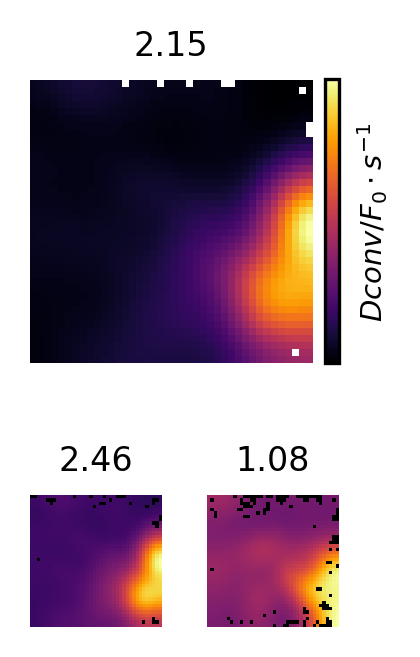

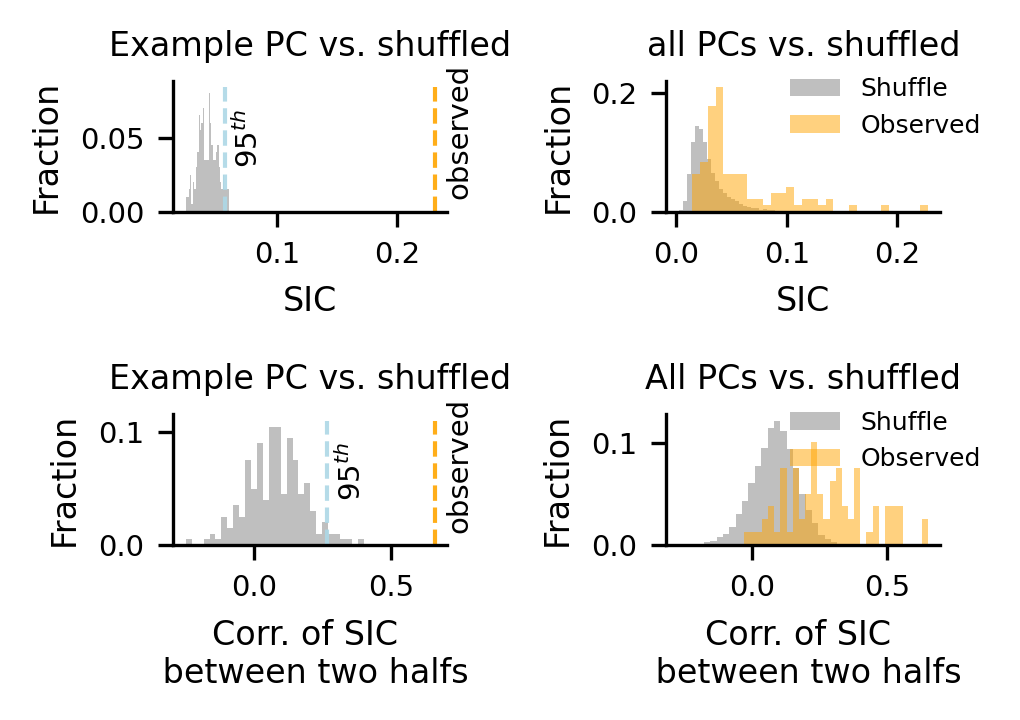

In [206]:
SIC_shuffle_all = Potential_PC_results['SIC_shuffle_all']
SIC_real_all = Potential_PC_results['SIC_real_all']
potentialPC_maps = Potential_PC_results['potentialPC_maps']

with open(os.path.join(savefolder, 'Potential_PC_results_halfs.pickle'), 'rb') as f:
    Potential_PC_results_halfs = pickle.load(f)
Corr_real_all = Potential_PC_results_halfs['Corr_real_all']
Corr_shuffle_all = Potential_PC_results_halfs['Corr_shuffle_all']
potentialPC_maps_halfs = Potential_PC_results_halfs['potentialPC_maps_halfs']

#plot example tuning maps
fig = plt.figure(figsize=(1.5,2.5), dpi=300)
labelsize = 8
ticksize = 7
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1.5, 1])

key = 5

ax0 = fig.add_subplot(gs[0, 0:2])

#plot the example tuning map
map = potentialPC_maps[key]

#imshow the map
ax0.imshow(map, cmap='inferno')
#axis off ticks off
ax0.axis('off')
ax0.set_xticks([]); ax0.set_yticks([])
#add peak as title on the top
ax0.set_title('{:.2f}'.format(np.nanmax(map)), fontsize=labelsize)

#add colorbar and label in a latex format Dconv/F_0 /dot s^-1, align the colorbar length with the plot
cbar = ax0.figure.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=ticksize)
# Set label size as the desired fontsize
cbar.set_label('$Dconv/F_0 \cdot s^{-1}$', fontsize=ticksize)

ax1 = fig.add_subplot(gs[1, 0])
#plot the example tuning map
map1, map2 = potentialPC_maps_halfs[key]

#imshow the map1
ax1.imshow(map1, cmap='inferno')
#axis off ticks off
ax1.axis('off')
ax1.set_xticks([]); ax1.set_yticks([])
#add peak as title on the top
ax1.set_title('{:.2f}'.format(np.nanmax(map1)), fontsize=labelsize)

ax2 = fig.add_subplot(gs[1, 1])
#imahow the map2
ax2.imshow(map2, cmap='inferno')
#axis off ticks off
ax2.axis('off')
ax2.set_xticks([]); ax2.set_yticks([])
#add peak as title on the top
ax2.set_title('{:.2f}'.format(np.nanmax(map2)), fontsize=labelsize)

plt.tight_layout()

plt.savefig('../Figures/Figure3_tuningmaps.pdf', dpi=300, bbox_inches='tight')


##############################################################################################################
##############################################################################################################
##############################################################################################################

#plot stats
fig = plt.figure(figsize=(3.5,2.5), dpi=300)
labelsize = 8
ticksize = 7
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

numbins = 30

ax1 = fig.add_subplot(gs[0, 0])

#plot the histgram of SIC of the selected neuron, normalized histogram
SIC_shuffle_selected = SIC_shuffle_all[key]
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(SIC_shuffle_selected, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
ax1.bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')
#add 95 percentile of the SIC_shuffle_selected as a vertical line
percentile_95 = np.percentile(SIC_shuffle_selected, 95)
yuplim = ax1.get_ylim()[1]
ax1.plot([percentile_95, percentile_95], [0, yuplim], color='lightblue', linewidth=1, alpha=0.9, linestyle='--')
#add text to label the percentile marked as 95^{th}
ax1.text(percentile_95+0.02, 0.35*yuplim, '95$^{th}$', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom', rotation='vertical')
#add the real SIC as a orange vertical line, dashed
SIC_real_selected = SIC_real_all[key]
ax1.plot([SIC_real_selected, SIC_real_selected], [0, yuplim], color='orange', linewidth=1, alpha=0.9, linestyle='--')
#add text to label the real SIC, vertical display
ax1.text(SIC_real_selected+0.02, 0.1*yuplim, 'observed', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom', rotation='vertical')
#right and top axis off
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#x y labels
ax1.set_xlabel('SIC', fontsize=labelsize)
ax1.set_ylabel('Fraction', fontsize=labelsize)
ax1.set_title('Example PC vs. shuffled', fontsize=labelsize)
ax1.tick_params(labelsize=ticksize)

ax2 = fig.add_subplot(gs[0, 1])

#plot the histogram of SIC of all neurons
shuffle_all = np.concatenate(list(SIC_shuffle_all.values()))
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(shuffle_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
ax2.bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')

real_all = np.array(list(SIC_real_all.values()))
#count the number of elements in each bin  using np.histogram for SIC_real_all
counts, bins = np.histogram(real_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the bar with facecolor edgecolor as orange
ax2.bar(bins[:-1], counts, width=bins[1]-bins[0], color='orange', alpha=0.5, label='Observed')
#histtype='step', 

#put the legend outside the plot on the right side
ax2.legend(fontsize=6, frameon=False, bbox_to_anchor=(0.8, 1.2), loc='upper center')
#axs[0].set_xlabel('Spatial information content', fontsize=labelsize)
ax2.set_ylabel('Fraction', fontsize=labelsize)
ax2.tick_params(labelsize=ticksize)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#title
ax2.set_title('all PCs vs. shuffled', fontsize=labelsize)

#x y labels
ax2.set_xlabel('SIC', fontsize=labelsize)
ax2.set_ylabel('Fraction', fontsize=labelsize)

##############################################################################################################
#plot the histgram of correlation of the selected neuron, normalized histogram
ax3 = fig.add_subplot(gs[1, 0])

Corr_shuffle_selected = Corr_shuffle_all[key]
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(Corr_shuffle_selected, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
ax3.bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')
#add 95 percentile of the Corr_shuffle_selected as a vertical line
percentile_95 = np.percentile(Corr_shuffle_selected, 95)
yuplim = ax3.get_ylim()[1]
ax3.plot([percentile_95, percentile_95], [0, yuplim], color='lightblue', linewidth=1, alpha=0.9, linestyle='--')
#add text to label the percentile marked as 95^{th}
ax3.text(percentile_95+0.09, 0.35*yuplim, '95$^{th}$', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom', rotation='vertical')
#add the real SIC as a orange vertical line, dashed
Corr_real_selected = Corr_real_all[key]
ax3.plot([Corr_real_selected, Corr_real_selected], [0, yuplim], color='orange', linewidth=1, alpha=0.9, linestyle='--')
#add text to label the real SIC
ax3.text(Corr_real_selected+0.09, 0.1*yuplim, 'observed', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom', rotation='vertical')
#right and top axis off
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
#x y labels
ax3.set_xlabel('Corr. of SIC \n between two halfs', fontsize=labelsize)
ax3.set_ylabel('Fraction', fontsize=labelsize)
ax3.set_title('Example PC vs. shuffled', fontsize=labelsize)
ax3.tick_params(labelsize=ticksize)

##############################################################################################################
#plot the histogram of Correlation of all neurons
ax4 = fig.add_subplot(gs[1, 1])
shuffle_all = np.concatenate(list(Corr_shuffle_all.values()))
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(shuffle_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
ax4.bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')

real_all = np.array(list(Corr_real_all.values()))
#count the number of elements in each bin  using np.histogram for SIC_real_all
counts, bins = np.histogram(real_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the bar with facecolor edgecolor as orange
ax4.bar(bins[:-1], counts, width=bins[1]-bins[0], color='orange', alpha=0.5, label='Observed')
#histtype='step', 

#put the legend outside the plot on the right side
ax4.legend(fontsize=6, frameon=False, bbox_to_anchor=(0.8, 1.2), loc='upper center')
#axs[0].set_xlabel('Spatial information content', fontsize=labelsize)
ax4.set_ylabel('Fraction', fontsize=labelsize)
ax4.tick_params(labelsize=ticksize)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
#title
ax4.set_title('All PCs vs. shuffled', fontsize=labelsize)

#x y labels
ax4.set_xlabel('Corr. of SIC \n between two halfs', fontsize=labelsize)
ax4.set_ylabel('Fraction', fontsize=labelsize)

plt.tight_layout()

plt.savefig('../Figures/Figure3_stats.pdf', dpi=300, bbox_inches='tight')


### 5, plot example tuning maps

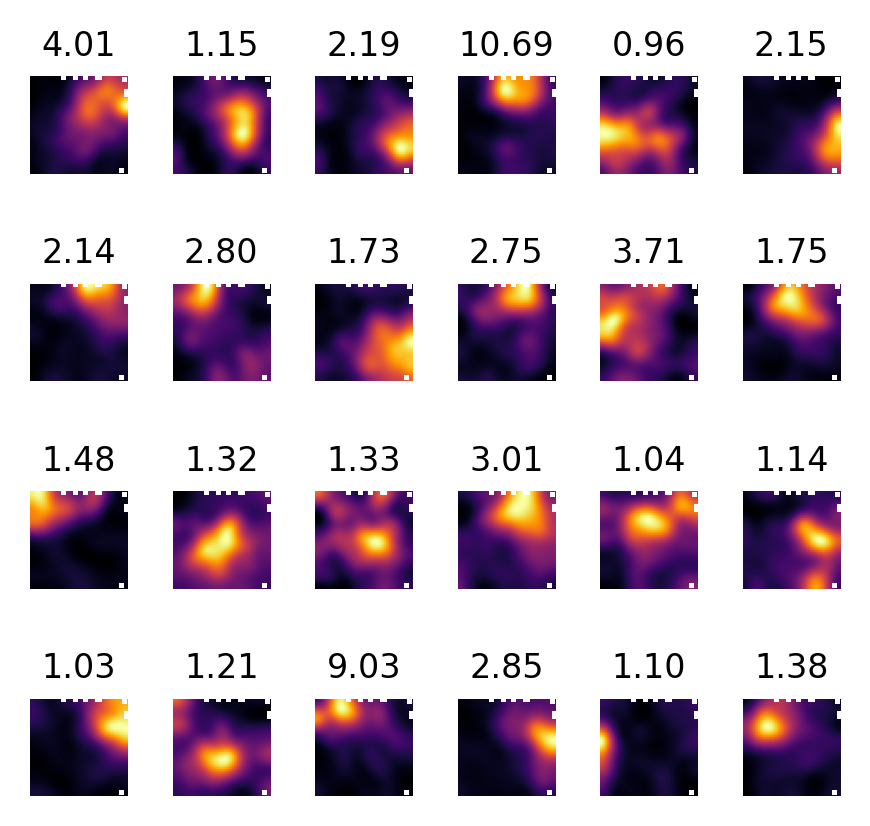

In [218]:

#plot all valid maps in subplots
num = 24
#calculate the number of rows and columns, make cols 2 times of rows
rows = 4
cols = 6

#
labelsize = 10
ticksize = 8

#set the figure size
fig = plt.figure(figsize=(3,3), dpi=300)

for i, (k, v) in enumerate(potentialPC_maps.items()):
    plt.subplot(rows, cols, i+1)
    plt.imshow(v, cmap='inferno')
    #ticks off
    plt.xticks([]); plt.yticks([])
    #add peak value as title of each subplot, and move it down a little bit
    peak = np.nanmax(v)
    plt.title('{:.2f}'.format(peak), fontsize=ticksize, pad=5)
    #box off
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    if i>=num-1:
        break

plt.tight_layout()

plt.savefig('../Figures/Figure3_fewtuningmaps.pdf', dpi=300, bbox_inches='tight')


### 6, plot several half maps

In [223]:
potentialPC_maps_halfs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 28, 31, 35, 36, 37, 43, 54, 56, 57, 58, 63, 65, 70, 71, 72, 73, 77, 86, 95, 96, 97, 99, 108, 111, 112, 113, 115, 123, 128, 130, 131, 132, 143, 145, 158, 163, 169, 172, 174, 179, 196, 199, 204, 210, 221, 232, 244, 250, 278, 280, 293, 310, 311, 315, 367, 536, 928])

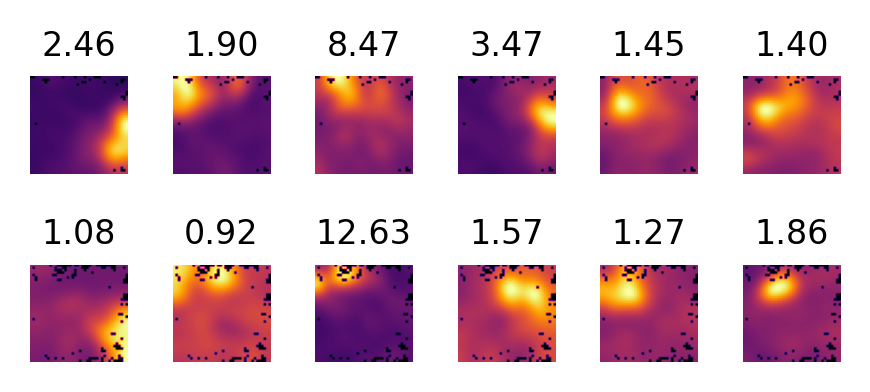

In [233]:
#load Potential_PC_results_halfs.pickle from the savefolder
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
with open(os.path.join(savefolder, 'Potential_PC_results_halfs.pickle'), 'rb') as f:
    Potential_PC_results_halfs = pickle.load(f)
potentialPC_maps_halfs = Potential_PC_results_halfs['potentialPC_maps_halfs']

#
labelsize = 10
ticksize = 8

#set the figure size
fig = plt.figure(figsize=(3,1.5), dpi=300)

keys = [5,12,23,24,31,35]
num = len(keys)

gs = fig.add_gridspec(2, num)

for i, k in enumerate(keys):
    v = potentialPC_maps_halfs[k]
    map1 = v[0]
    ax0 = fig.add_subplot(gs[0, i])
    ax0.imshow(map1, cmap='inferno')
    #ticks off
    ax0.set_xticks([]); ax0.set_yticks([])
    #add peak value as title of each subplot, and move it down a little bit
    peak = np.nanmax(v[0])
    ax0.set_title('{:.2f}'.format(peak), fontsize=ticksize, pad=5)
    #axis off
    ax0.axis('off')
    
    map2 = v[1]
    ax1 = fig.add_subplot(gs[1, i])
    ax1.imshow(map2, cmap='inferno')
    #ticks off
    ax1.set_xticks([]); ax1.set_yticks([])
    #add peak value as title of each subplot, and move it down a little bit
    peak = np.nanmax(v[1])
    ax1.set_title('{:.2f}'.format(peak), fontsize=ticksize, pad=5)
    #axis off
    ax1.axis('off')
    
plt.tight_layout()
plt.savefig('../Figures/Figure3_fewtuningmaps_halfs.pdf', dpi=300, bbox_inches='tight')
